# Carga de paquetes y TPUs

In [1]:
import numpy as np 
import pandas as pd 
import os

import tensorflow as tf
from functools import partial
import matplotlib.pyplot as plt

from kaggle_datasets import KaggleDatasets

import random
from random import seed

import tensorflow.keras.backend as K

import re

from sklearn.model_selection import KFold

! pip install -q efficientnet
import efficientnet.tfkeras as efn

import seaborn as sns
import math

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

In [2]:
# Siempre se va a intentar hacer 
# uso de las TPU si están disponibles

DEVICE = "TPU"

if DEVICE == "TPU":
    print("conectando a la TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print("Ejecutando en TPU:" , tpu.master())
    except ValueError:
        print("No se ha podido conectar a la TPU")
        tpu = None

    if tpu:
        try:
            print("Inicializando la  TPU ")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU inicializada")
        except _:
            print("Fallo al iniciar la TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Usando la estrategia por defecto de CPU/GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs disponibles: ", len(tf.config.experimental.list_physical_devices("GPU")))
    print("Lista de dispositivos:", tf.config.experimental.list_physical_devices("GPU"))


conectando a la TPU...
Ejecutando en TPU: grpc://10.0.0.2:8470
Inicializando la  TPU 
TPU inicializada


**Variables**

In [3]:
## VARIABLES

# Valor que establece el buffer_size 
# en operaciones como la de prefetch
AUTOTUNE = tf.data.experimental.AUTOTUNE

REPLICAS = strategy.num_replicas_in_sync
print("REPLICAS: " +str(REPLICAS))

# Paths para la carga de los dataset
GCS_PATH = KaggleDatasets().get_gcs_path("siim-isic-melanoma-classification")
GCS_PATH2 = KaggleDatasets().get_gcs_path("melanoma-512x512")
GCS_PATH3 = KaggleDatasets().get_gcs_path("isic2019-512x512")
GCS_PATH4 = KaggleDatasets().get_gcs_path("malig-data-aug")

# Variables para la configuración del modelo

# Se define el tamaño del batch
# Sin TPU tendrá un tamaño de 32 y con TPU de 256 (=32*8)
BATCH_SIZE = 32 * REPLICAS
EPOCHS     = 120
FOLDS      = 5
TTA        = 7
TTA_VALID  = 60

# Variables para la transformación de las imágenes
IMAGE_SIZE = [512, 512]
IMG_SIZE   = 512
CROP_SIZE  = 480

# Se establece el valor de las semillas
SEED       = 1701
tf.random.set_seed(SEED)
seed(SEED)

REPLICAS: 8


In [4]:
# Se obtienen el listado de los tfrecords a utilizar
FILENAMES = tf.io.gfile.glob(GCS_PATH2 + "/train*.tfrec")
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH2 + "/test*.tfrec")

# Funciones

In [5]:
# Función que decodifica una imagen, la normaliza
# y la cambia a un tamaño apto para la red y el TPU
def decodeImage(image, augmentation):
    # Se decodifica la imagen con la librería tensorflow
    image = tf.image.decode_jpeg(image, channels=3)
    
    if augmentation:
        # Se recorta la imagen si hay dataAugmentation
        image = tf.image.random_crop(image,[CROP_SIZE,CROP_SIZE,3])
    
    # Normaliza la imagen convirtiendo los valores a un rango de [0,1]
    image = tf.cast(image, tf.float32)/ 255.0  
    
    # Se cambia el tamaño de la imagen
    image = tf.image.resize(image, [*IMAGE_SIZE])
    
    # Se cambia la forma de la imagen,
    # ya que es necesario para que tenga las dimensiones que espera la TPU
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    
    return image

# Función que establece como leer el tfrecord
# devolviendo la imagen y su etiqueta o
# la imagen o su nombre asociado

def readTfrecord(example, labeled, imageName, augmentation):
   
    if labeled:
        
        # Si viene del conjunto de train
        tfrecord_format = (
        {
            "image": tf.io.FixedLenFeature([], tf.string),
            "target": tf.io.FixedLenFeature([], tf.int64),
        })
        
        # Example tendrá dos elementos, imagen y label
        example = tf.io.parse_single_example(example, tfrecord_format) 
        
        # Se decodifica la imagen y se realiza el cast de la etiqueta
        image = decodeImage(example["image"],augmentation)
        label = tf.cast(example["target"], tf.int32)
        
        return image, label
    
    else:
        
         # Si viene del conjunto de test
        tfrecord_format = (
        {
            "image": tf.io.FixedLenFeature([], tf.string),
            "image_name": tf.io.FixedLenFeature([], tf.string),
        })
        
        # Example tendrá dos elementos, imagen y nombre
        example = tf.io.parse_single_example(example, tfrecord_format)
        
        # Se decodifica la imagen
        image = decodeImage(example["image"],augmentation)
        return image, example["image_name"] if imageName else 0

    
# Función de data augmentation, preparada para aplicarse en
# una transformación map, 
# recibe la imagen a ser tratada y la clase

def dataAugmentation(image, label):
    # En la función 'getTrainingDataset()' se usará 'dataset.prefetch (AUTO)' lo que permitirá
    # que la CPU se encargue de la canalización de los datos mientras
    # que la TPU sólo realiza cálculo de gradientes aumentando la eficiencia

    if random.random() < .75:
        # Función que realiza un volteo aleatorio 
        # de izquierda/derecha sobre la imagen
        image = tf.image.random_flip_left_right(image)
    
    if random.random() < .75:
        # Función que realiza un volteo aleatorio
        # de arriba/abajo sobra la imagen
        image = tf.image.random_flip_up_down(image)

    if random.random() < .5:
        # Función que ajusta el brillo, el segundo valor
        # indica el rango máximo/mínimo
        image = tf.image.random_brightness(image, 0.2)

    if random.random() < .5:
        # Función que ajusta el tono de la imagen, el
        # segundo valor indica el rango máximo/mínimo
        image = tf.image.random_hue(image, 0.09, SEED)

    if random.random() < .5:
        # Funcion que ajusta la saturacion de la imagen,
        # indicando específicamente el mínimo y el máximo
        image = tf.image.random_saturation(image, 0.6, 1.4, SEED)

    if random.random() < .5:
        # Función que ajusta el contraste de la imagen,
        # indicando específicamente el mínimo y el máximo
        image = tf.image.random_contrast(image, 0.7, 1.3, SEED)

    if random.random() < .5:
        # Función que rota la imagen 90º de forma aleatoria
        image = tf.image.rot90(image, random.randint(0,3))
        
    if random.random() < .5:
        # Función que traspone la imagen
        image = tf.image.transpose(image)

    return image, label  

# Función que carga los tfrecords y los transforma en imagenes etiquetas/nombres
# pudiendo aplicar además data agumentation 
# y mezclado de los elementos
def loadDataset(filenames, labeled=True, imageName=False, shuffle=False, augmentation=False):
    
    # Se cargan los tfrecords en un dataset
    dataset = tf.data.TFRecordDataset(filenames)

    # Se extraen los elementos con la función 'readTfrecord'
    dataset = dataset.map(
        partial(readTfrecord, labeled=labeled,imageName=imageName,augmentation=augmentation), num_parallel_calls=AUTOTUNE)
    
    # Tras crear los tfrecords con 
    # datos de lesiones malignas aumentadas
    # no se obtiene mejor resultado al hacer dataAugmentation
    # sobre todo el dataset
    
    #if augmentation:
        # Se aplica data agumentation
    #    dataset = dataset.map(dataAugmentation,num_parallel_calls=AUTOTUNE)
        
    if shuffle: 
        # Se mezclan los elementos
        dataset = dataset.shuffle(BATCH_SIZE * SEED)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        dataset = dataset.with_options(opt)
    
    
    return dataset

# Función que devuelve un dataset, que tras la carga de los tfrecords
# aplica distintas modificaciones como el prefetch o batch
def getDataset(filenames, labeled=True, imageName=False, repeat = False, shuffle=False, augmentation= False):
    
    # Se cargan los tfrecords
    dataset = loadDataset(filenames, labeled=labeled, imageName = imageName, shuffle=shuffle, augmentation=augmentation)
    
    # Se cachea el dataset
    dataset = dataset.cache()
    
    if repeat:
        
        # Se estable repetición infinita
        # para mejorar el rendimiento entre épocas
        dataset = dataset.repeat()
        
    # Esta función permite que la CPU se encargue de la canalización de los datos mientras
    # que la TPU sólo realiza cálculo de gradientes aumentando la eficiencia    
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    # Se establece el tamaño del batch
    dataset = dataset.batch(BATCH_SIZE)
    
    return dataset

# Función igual que la anterior, pero que realiza augmentation
# para poder realizar el TTA
def loadDatasetAug(filenames, labeled=True, imageName=False, shuffle=False, augmentation=False):
    
    dataset = tf.data.TFRecordDataset(filenames)

    dataset = dataset.map(
        partial(readTfrecord, labeled=labeled,imageName=imageName,augmentation=augmentation), num_parallel_calls=AUTOTUNE)
    
    # Para aplicar TTA
    if augmentation:
        dataset = dataset.map(dataAugmentation,num_parallel_calls=AUTOTUNE)
        
    if shuffle: 
        dataset = dataset.shuffle(BATCH_SIZE * SEED)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        dataset = dataset.with_options(opt)
    
    
    return dataset

def getDatasetAug(filenames, labeled=True, imageName=False, repeat = False, shuffle=False, augmentation= False):
    
    dataset = loadDatasetAug(filenames, labeled=labeled, imageName = imageName, shuffle=shuffle, augmentation=augmentation)
    
    dataset = dataset.cache()
    
    if repeat:
        dataset = dataset.repeat()
        
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    
    return dataset

# Función que devuelve el número de elementos en un tfrecord
# sin el coste computacional de contar los elementos
def countDataItems(filenames):
    # El número de elementos está escrito en el propio nombre del fichero .tfrec
    # Por ejemplo: test00-687.tfrec tiene 687 elementos
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

# Función que muestra la matriz de confusión
# y las métricas asociadas a la función 'classification_report'
def metrics(validTest, numValidTest, probab, fld):
    
    # Se obtienen las etiquetas y colocan todas en un batch
    validLabelDs      = validTest.map(lambda image, label: label).unbatch()
    validLabels       = next(iter(validLabelDs.batch(numValidTest))).numpy().astype("U")
    
    # Se obtien los valores de la matriz de confusión
    conf_matrix = confusion_matrix(validLabels.astype(int),tf.greater(probab, .5) )
    
    # Se dibuja la matriz de confusión
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1.75)

    ax = sns.heatmap(conf_matrix,annot=True, fmt="d", cbar = False, cmap="coolwarm");
    ax.invert_yaxis()

    plt.title("Matriz confusión")
    plt.ylabel("Clase real")
    plt.xlabel("Clase predicha")
    plt.show()
    plt.savefig('confusion%i.png'%fld)
    
    # Se imprimen los resultados de la función 'classification_report' y 
    # 'roc_auc_score'
    print(classification_report(validLabels.astype(int),tf.greater(probab, .5)))
    print("ROC AUC score: {}".format(roc_auc_score(validLabels.astype(int),tf.greater(probab, .5), average='macro')))
    
    fpr, tpr, thresholds = roc_curve(validLabels.astype(int),tf.greater(probab, .5))
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0, 1], [0, 1], "k--")
    plt.ylabel("Ratio de Verdaderos Positivos (Recall)")
    plt.xlabel("Ratio de Falsos Positivos")
    plt.show()
    plt.savefig('roc%i.png'%fld)

In [6]:
# Se configura la función de earlyStopping 
earlyStopping = tf.keras.callbacks.EarlyStopping(
    patience=40, restore_best_weights=True, verbose=1)

In [7]:
# Función que devuelve el modelo basado 
# en una red EfficientNet
def makeModel():
    
    # La base del modelo se basa en una red EfficientNet
    # que no incluye la primera capa y con los pesos
    # calculados para imagenet
    base = efn.EfficientNetB7(
        input_shape=(*IMAGE_SIZE, 3), include_top=False, weights="imagenet"
    )
    
    # Se define la primera capa con el tamaño de nuestras imágenes
    inputs = tf.keras.layers.Input([*IMAGE_SIZE, 3])
    x = tf.keras.applications.efficientnet.preprocess_input(inputs)
    
    # Se añade la primera capa al modelo base, una capa avergapooling,
    # una capa de dropout y la última capa con 
    # una sola neurona y activación sigmoide
    x = base(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    # Se compila el modelo para hacer uso de 
    # un optimizador Adam con un learning_rate = 0.00001
    # una función loss binary_crossentropy
    # y métricas basadas en AUC
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
        loss="binary_crossentropy",
        metrics=tf.keras.metrics.AUC(name="auc"),
    )

    return model

In [8]:
# Se obtiene el dataset de test y 
# el número de imágenes para tener todos los
# ids de las imagenes de test
testDataset  = getDataset(TEST_FILENAMES, labeled=False, imageName=False)
NUM_TEST_IMAGES = countDataItems(TEST_FILENAMES)

testDatasetName = getDataset(TEST_FILENAMES, labeled=False, imageName=True)
testIdsDs       = testDatasetName.map(lambda image, idnum: idnum).unbatch()

# Se obtienen los ids en un sólo batch
testIds         = next(iter(testIdsDs.batch(NUM_TEST_IMAGES))).numpy().astype("U")                 

# Construcción del modelo, evaluación y predicción

Fold [0]
[ 0  2  3  4  5  6  8  9 10 11 13 14]
[ 1  7 12]
258441216/258434480 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
efficientnet-b7 (Functional) (None, 16, 16, 2560)      64097680  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2561      
Total params: 64,100,241
Trainable params: 63,789,521
Non-trainable params: 310,720
__________________________________________________

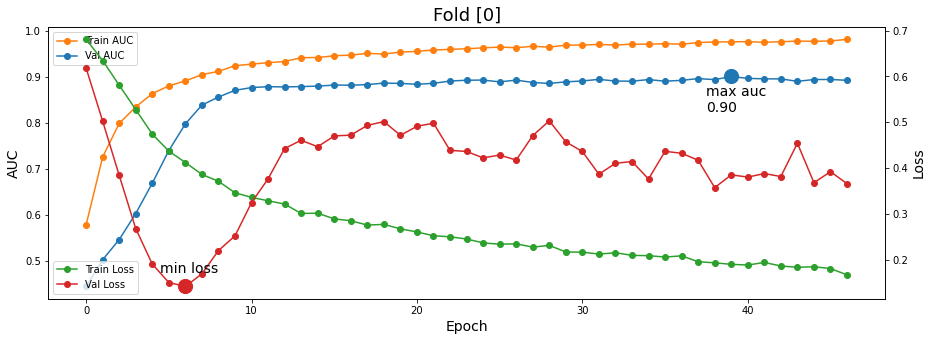

26/26 [==============================] - 10s 328ms/step


<Figure size 432x288 with 0 Axes>

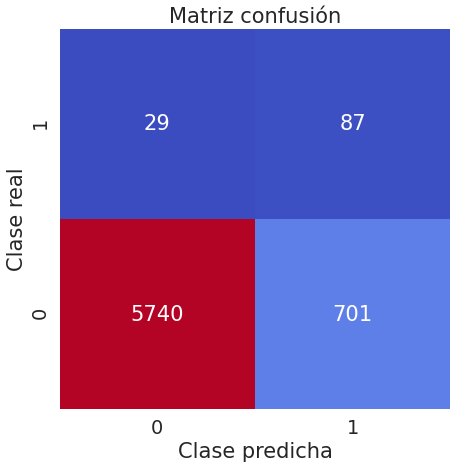

              precision    recall  f1-score   support

           0       0.99      0.89      0.94      6441
           1       0.11      0.75      0.19       116

    accuracy                           0.89      6557
   macro avg       0.55      0.82      0.57      6557
weighted avg       0.98      0.89      0.93      6557

ROC AUC score: 0.8205829840086942


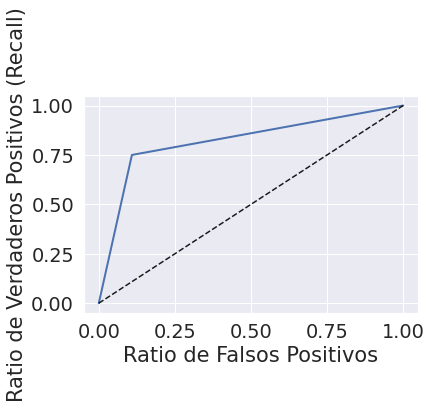

43/43 [==============================] - 16s 341ms/step
Generando el fichero submission.csv
43/43 [==============================] - 18s 395ms/step
Generando el fichero submissionTTA.csv



Fold [1]
[ 0  1  3  4  5  6  7  8 10 11 12 14]
[ 2  9 13]



Fold [2]
[ 1  2  3  4  5  7  9 10 11 12 13 14]
[0 6 8]



Fold [3]
[ 0  1  2  4  6  7  8  9 10 12 13 14]
[ 3  5 11]



Fold [4]
[ 0  1  2  3  5  6  7  8  9 11 12 13]
[ 4 10 14]





<Figure size 432x288 with 0 Axes>

In [9]:
# Se dividen los ficheros tfrecord previamente estratificados
# en tantos elmentos como se haya dispuesto en la variable FOLDS
skf = KFold(n_splits=FOLDS,shuffle=True,random_state=SEED)

# Contador del número de folds
fld = 0

for idxT,idxV in skf.split(FILENAMES):
    
    # Impresión de la división de folds para train y test
    print("Fold ["+str(fld)+"]")
    print(idxT)
    print(idxV)
    
    # Después de las pruebas con múltiples folds
    # la división de datos que produce el fold cero es la más optima
    if fld == 0:
    
        # Se obtienen los tfrecords que formaran parte del train
        TRAINING_FILENAMES  = tf.io.gfile.glob([GCS_PATH2 + "/train%.2i*.tfrec"%x for x in idxT])
        # además de sus correspondientes datos augmentados para la clase maligna
        TRAINING_FILENAMES += tf.io.gfile.glob([GCS_PATH4 + "/aug%.2i*.tfrec"%x for x in idxT])

        # Se añaden los datos de 2018 y 2019
        TRAINING_FILENAMES += tf.io.gfile.glob(GCS_PATH3 + "/train*.tfrec")

        # Se obtienen los tfrecords que formaran parte del conjunto de validación
        VALID_FILENAMES    = tf.io.gfile.glob([GCS_PATH2 + "/train%.2i*.tfrec"%x for x in idxV])
        # además de sus correspondientes datos augmentados para la clase maligna
        #VALID_FILENAMES += tf.io.gfile.glob([GCS_PATH4 + "/aug%.2i*.tfrec"%x for x in idxV])


        # Se configura la función de checkpoint para observar la variable
        # val_auc y grabar sólo los pesos
        checkpoint = tf.keras.callbacks.ModelCheckpoint(
            "melanomaModel_%i.h5"%fld,
            monitor="val_auc",
            mode="max",
            verbose=1,
            save_best_only=True,
            save_weights_only=True)

        # Se empieza con una sesión nueva y se crea el modelo
        K.clear_session()
        with strategy.scope():
            model = makeModel()

        model.summary()

        # Se entrena el modelo, es importante configurar de manera correcta el parámetro
        # steps_per_epoch para poder hacer un uso óptimo de las TPU
        history = model.fit(
            getDataset(TRAINING_FILENAMES,repeat= True, shuffle= True, augmentation= True),
            epochs=EPOCHS,
            validation_data=getDataset(VALID_FILENAMES, augmentation= False),
            callbacks=[earlyStopping,checkpoint],
            steps_per_epoch= (countDataItems(TRAINING_FILENAMES))/BATCH_SIZE//REPLICAS,
            verbose = 1)

        # Se dibuja la gráfica con el history del modelo
        plt.figure(figsize=(15,5))

        # Se dibujan los valores de auc y val_auc
        plt.plot(history.history["auc"],'-o',label="Train AUC",color="#ff7f0e")
        plt.plot(history.history["val_auc"],'-o',label="Val AUC",color="#1f77b4")

        # Se calcula el mejor valor para val_auc
        x = np.argmax( history.history["val_auc"] )
        y = np.max( history.history["val_auc"] )

        # Se calculan las distancias 
        # para los límites de ambos ejes
        xdist = plt.xlim()[1] - plt.xlim()[0]
        ydist = plt.ylim()[1] - plt.ylim()[0]

        # Se dibuja un punto para resaltar 
        # el valor máximo de val_auc 
        plt.scatter(x,y,s=200,color="#1f77b4")

        # Se añade el texto
        plt.text(x-0.03*xdist,y-0.13*ydist,"max auc\n%.2f"%y,size=14)

        plt.ylabel("AUC",size=14); 
        plt.xlabel("Epoch",size=14)
        plt.legend(loc=2)

        # Se crea el segundo eje X dentro del gráfico anterior
        plt2 = plt.gca().twinx()

        # Se dibujan los valores de loss y val_loss
        plt2.plot(history.history["loss"],'-o',label="Train Loss",color="#2ca02c")
        plt2.plot(history.history["val_loss"],'-o',label="Val Loss",color="#d62728")

        # Se calcula el mínimo valor para val_loss
        x = np.argmin( history.history["val_loss"] )
        y = np.min( history.history["val_loss"] )

        # Se calcula la distancia 
        # para el límite del ejes
        ydist = plt.ylim()[1] - plt.ylim()[0]

        # Se dibuja un punto para resaltar 
        # el valor mínimo de val_loss 
        plt.scatter(x,y,s=200,color="#d62728")

        # Se añade el texto
        plt.text(x-0.03*xdist,y+0.05*ydist,"min loss",size=14)

        plt.ylabel("Loss",size=14)
        plt.title("Fold ["+str(fld)+"]",size=18)

        plt.legend(loc=3)
        plt.show()

        plt.savefig('historyPlot_%i.png'%fld)

        # Se carga en el modelo, el mejor conjunto de pesos
        model.load_weights("./melanomaModel_%i.h5"%fld)

        # Se aplica TTA a para el conjunto de validación
        VALID_FILENAMES  = tf.io.gfile.glob([GCS_PATH2 + "/train%.2i*.tfrec"%x for x in idxV])
        
        predTTA = []
        
        for i in range(TTA_VALID):
            if i == 0:
                vadliData =  getDataset(VALID_FILENAMES,repeat= False, shuffle= False, augmentation= True, labeled=False, imageName=False)
                predTTA.append(model.predict(vadliData, verbose = 1)) 
            else:
                vadliDataAug =  getDatasetAug(VALID_FILENAMES,repeat= False, shuffle= False, augmentation= True, labeled=False, imageName=False)
                predTTA.append(model.predict(vadliDataAug, verbose = 1))
        
        probabilitesTTA = np.mean(predTTA,axis =0)
        
        # Se obtiene el dataset de validación
        validTest  = getDataset(VALID_FILENAMES)

        # Se cuentan sus elementos
        numValidTest      = countDataItems(VALID_FILENAMES)

        # Se obtienen las predicciones para el conjunto de validación
        probabilitiesValid = model.predict(validTest, verbose=1)

        # Se dibujar las métricas
        metrics(validTest, numValidTest, probabilitesTTA, fld)

        # Se calculan las predicciones para el conjunto de test
        probabilities = model.predict(testDataset, verbose=1)

        # Se genera el fichero para poder subir los resultados 
        # al reto kaggle
        print("Generando el fichero submission.csv")
        predDf = pd.DataFrame({"image_name": testIds, "target": np.concatenate(probabilities)})

        sub = pd.read_csv("/kaggle/input/siim-isic-melanoma-classification/sample_submission.csv")
        del sub["target"]
        sub = sub.merge(predDf, on="image_name")

        sub.to_csv("complete_data_%i.csv"%fld, index=False)
        sub.head()

        # En caso de que se haya seleccionado TTA
        # se procede a calcular las predicciones del conjunto de test
        # la primera vez sin aplicar data augmentation y el resto
        # con data augmentation
        predTTA = []

        for i in range(TTA):
            if i == 0:
                testDataAug =  getDataset(TEST_FILENAMES,repeat= False, shuffle= False, augmentation= True, labeled=False, imageName=False)
                predTTA.append(model.predict(testDataAug, verbose = 1)) 
            else:
                testDataAug =  getDatasetAug(TEST_FILENAMES,repeat= False, shuffle= False, augmentation= True, labeled=False, imageName=False)
                predTTA.append(model.predict(testDataAug, verbose = 1))

        # Se genera un segundo fichero
        probabilitesTTA = np.mean(predTTA,axis =0)
        predDfTTA = pd.DataFrame({"image_name": testIds, "target": np.concatenate(probabilitesTTA)})

        print("Generando el fichero submissionTTA.csv")

        sub = pd.read_csv("/kaggle/input/siim-isic-melanoma-classification/sample_submission.csv")
        del sub["target"]
        sub = sub.merge(predDfTTA, on = "image_name")

        sub.to_csv("complete_dataTTA_%i.csv"%fld, index=False)
        sub.head()

    print("\n\n")
    fld += 1
